In [ ]:
!pip install hdbscan

In [ ]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform

In [ ]:
df = pd.read_excel('/content/tSNE_Data.xlsx')

In [ ]:
df=df.to_numpy()

In [ ]:
df.shape

(755, 2)

In [ ]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(df)
label= clusterer.labels_

In [ ]:
u_labels = np.unique(label)
u_labels

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25])

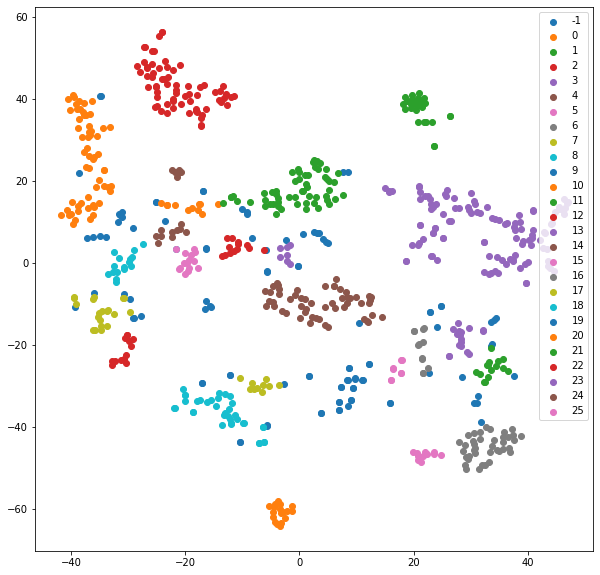

In [ ]:
#plotting the results:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()

In [ ]:
cluster_list = []   
for i in u_labels:
  cluster_list.append(df[label == i])

In [ ]:
# Function to find the backbone points
def find_backbone_points(C,l):
  """
  C : cluster
  l: no. of nearest neighbours  (user-input)

  Returns the backbone points of the cluster C.
  """
  
  backbone_points = []  # This list contains the index of the backbone points
  knn_list = [] # This list contains the information of nearest neighbors of each point in the cluster. 
  LD = [] # This list contains local density of each point in the cluster.
  knn = NearestNeighbors(n_neighbors=l+1) # Fit the nearest neighbors estimator from the training dataset.
  knn.fit(C)
  for i in range(len(C)):
    a = knn.kneighbors(C[i].reshape(1,-1))  # Finds the K-neighbors of a point and returns a            
    knn_list.append(a)                      # list containing indexes of those points  and the distances between the points.
    LD.append(l/a[0].sum()) # Adding Local density of each point to the list
  for i in range(len(C)): # Checking each point whether it is a backbone point
    ind = 0
    for j in range(1,l+1):
      if LD[i]>LD[knn_list[i][1][0][j]]:      # Condition for backbone point  # knn_list[i][1][0][j] gives the index of the nearest neighbor
        ind+=1
    if ind ==l:
      backbone_points.append(i)
  backbone_array = []     # This list contains the backbone points
  for i in backbone_points:
    backbone_array.append(C[i])
  backbone_array = np.array(backbone_array)
  return backbone_array


In [ ]:
# Function to find the minimum spanning tree
def minimum_spanning_tree(X, copy_X=True):
    """X are edge weights of fully connected graph"""
    if copy_X:
        X = X.copy()

    if X.shape[0] != X.shape[1]:
        raise ValueError("X needs to be square matrix of edge weights")
    n_vertices = X.shape[0]
    spanning_edges = []
    
    # initialize with node 0:                                                                                         
    visited_vertices = [0]                                                                                            
    num_visited = 1
    # exclude self connections:
    diag_indices = np.arange(n_vertices)
    X[diag_indices, diag_indices] = np.inf
    
    while num_visited != n_vertices:
        new_edge = np.argmin(X[visited_vertices], axis=None)
        # 2d encoding of new_edge from flat, get correct indices                                                      
        new_edge = divmod(new_edge, n_vertices)
        new_edge = [visited_vertices[new_edge[0]], new_edge[1]]                                                       
        # add edge to tree
        spanning_edges.append(new_edge)
        visited_vertices.append(new_edge[1])
        # remove all edges inside current tree
        X[visited_vertices, new_edge[1]] = np.inf
        X[new_edge[1], visited_vertices] = np.inf                                                                     
        num_visited += 1
    return np.vstack(spanning_edges)

In [ ]:
# BAVDens = The density of the region between a pair of adjacent vertices in MST of backbone points.
def BAVDens_finder(edge_list, q, backbone_array, C):
  """
  Input
  edge_list: list of edges in the MST of a cluster
  q: array containing distance between backbone points
  backbone_array: array containing backbone points of a cluster
  C : a cluster
  """
  BAVDens = [] # This list contains the BAVDens of a cluster
  for i in range(len(edge_list)):
    point1 = edge_list[i][0]
    point2 = edge_list[i][1]
    radius = q[point1,point2]/2     # radius of the circle with each MST edges as a diameter.
    midpoint = (backbone_array[point1] + backbone_array[point2])/2 # midpoint
    count = 0
    for j in C:
      if (j[0]-midpoint[0])**2+(j[1]-midpoint[1])**2 <= radius**2:    # condition for points inside the circle
        count+=1
    BavDen = count/((2*radius)**2)    # power ==> dim represents the dimensionality of the input data space (2)
    BAVDens.append(BavDen)
  return BAVDens

In [ ]:
def backbone_point_pairs(backbone_array1,backbone_array2):
  """
  To find nearest backbone point pairs based on the condition
  Input: backbone arrays of two clusters
  Return: nearest backbone_point_pairss between two clusters based on the condition
  """
  backbone_point_pairss = []
  m = backbone_array1.shape[0]  # no of backbone points in cluster 1
  n = backbone_array2.shape[0]  # no of backbone points in cluster 2
  distance_matrix = np.zeros(shape=(m,n)) # array containing distance between two backbone points
  for i in range(m):
    for j in range(n):
      distance_matrix[i,j] = round(math.sqrt((backbone_array1[i][0] - backbone_array2[j][0])**2 + (backbone_array1[i][1] - backbone_array2[j][1])**2),2)
  
  # finding nearest backbone_point_pairs using given condiion
  for i in range(m):
    row_min = min(distance_matrix[i,:])
    itemindex = np.where(distance_matrix[i,:]==row_min)
    col = itemindex[0][0]     
    col_min = min(distance_matrix[:,col])
    if row_min == col_min:
      backbone_point_pairss.append((i,col))
  return backbone_point_pairss

In [ ]:
def find_distance(array1,array2):
  return round(math.sqrt((array1[0] - array2[0])**2 + (array1[1] - array2[1])**2),2)

In [ ]:
# finding inter-cluster nearest data pairs
def find_index(backbone_point, cluster):
  """
  Finds the point in the cluster that is nearest to the backbone point
  """
  min_dist = 1000000
  index = None
  for i in range(len(cluster)):
    dist = find_distance(cluster[i],backbone_point)
    if dist < min_dist:
      min_dist = dist
      index = i
  return index

In [ ]:
def SSDD_index(cluster_list,l):
  """
  Input:
  cluster_list : The list containing datapoints of each clusters
  l : The number of nearest neighbors

  Return:
  DC: The density changes of a cluster along its backbone. In SSDD, DC is used as the inner-cluster validation measure. 
      A smaller DC(ci) value indicates a more homogeneous dense region in cluster ci, which represents a better formed cluster.
  """
  n = len(cluster_list)         # The number of clusters

  # Part 1
  backbone_array_list = [0]*n   # This list contains backbone points of each clusters as separate arrays
  qlist = [0]*n                 # This list contains distance between backbone points in a cluster 
  mst_edge_list = [0]*n         # This list contains the edges in the minimum spanning tree of each cluster 
  BAVDens_list = [0]*n          # This list contains BAVDens of each cluster
  DC=[0]*n                      # This list contains the density changes of a cluster along its backbone
  
  for i in range(n):
    for j in range(l,0,-1):
      backbone_array_list[i] = find_backbone_points(cluster_list[i],l=j)
      if backbone_array_list[i].shape[0] < 2:
        continue
      else:
        break

    qlist[i] = squareform(pdist(backbone_array_list[i]))
    mst_edge_list[i] = minimum_spanning_tree(qlist[i])
    BAVDens_list[i] = BAVDens_finder(mst_edge_list[i], qlist[i], backbone_array_list[i], cluster_list[i])
    DC[i] = (max(BAVDens_list[i])-min(BAVDens_list[i]))/max(BAVDens_list[i])

  # Part 2
  backbone_point_pairs_list = [0]*n   # The list of nearest backbone point pairs of clusters.
  for i in range(n):
    backbone_point_pairs_list[i]= []
    for j in range(n):
      pair = backbone_point_pairs(backbone_array_list[i],backbone_array_list[j])
      if i!=j:
        backbone_point_pairs_list[i].append(pair)
      else:
        backbone_point_pairs_list[i].append(None)

  data_pairs_list = [0]*n        # The list of inter-cluster nearest data pairs
  for i in range(n):
    data_pairs_list[i]= [0]*n
    for j in range(n):
      data_pairs_list[i][j]=[]
      if backbone_point_pairs_list[i][j]== None:
        data_pairs_list[i][j].append(None)
      else:
        for k in backbone_point_pairs_list[i][j]:
          index1 = find_index(backbone_array_list[j][k[1]], cluster_list[i])  # finds the point in cluster i that is nearest to the backbone point in cluster j of the given backbone point pair k
          index2 = find_index(backbone_array_list[i][k[0]], cluster_list[j])
          data_pairs_list[i][j].append((index1,index2))

  ICD_list=[0]*n # This list contains ICDs of each cluster
  for i in range(n):
    ICD = 0
    for j in mst_edge_list[i]:
      ICD+=qlist[i][j[0],j[1]]
    ICD/= len(mst_edge_list[i])
    ICD_list[i]=ICD

  mean_BNPDens = [0]*n # This list contains mean density of the region between Ci and all other clusters
  count_list = []
  for c in range(n):
    BNPDens_list=[]
    for d in range(n):
      if c!=d:
        for i in data_pairs_list[c][d]:
          if i==None: continue
          else:
            point1 = cluster_list[c][i[0]]
            point2 = cluster_list[d][i[1]]
            midpoint = (point1 + point2)/2 
            radius = min(ICD_list[c],ICD_list[d])/2
            count = 0
            for k in cluster_list[c]:
              if (k[0]-midpoint[0])**2+(k[1]-midpoint[1])**2 <= radius**2:
                count+=1  
            for k in cluster_list[d]:
              if (k[0]-midpoint[0])**2+(k[1]-midpoint[1])**2 <= radius**2:
                count+=1
            BNPD = count/((2*radius)**2)
            BNPDens_list.append(BNPD)
    mean_BNPDens[c] = mean(BNPDens_list)

  DR=[0]*n # This list contains inner-cluster density ratio of each clusters
  for i in range(n):
    DR[i] = mean_BNPDens[i]/max(mean_BNPDens[i],mean(BAVDens_list[i]))

  def SSDD(DC, DR, alpha):
    """
    DC: inner-cluster validation measure
    DR: Iinter-cluster validation measure
    alpha: parameter
    """
    beta = 1-alpha
    index_list = [0]*n
    for i in range(n):
      index_list[i] = alpha*DC[i] + beta*DR[i]
    SSDD_index = sum(index_list)/n
    return SSDD_index
  SSDD_index = SSDD(DC, DR, alpha=.5)

  return SSDD_index

In [ ]:
SSDD = SSDD_index(cluster_list,l = 5)
SSDD

0.30584853985011784